In [24]:
%run SPDEs.ipynb
%run Rule.ipynb
%run Noise.ipynb
%run Algorithm_1.ipynb
%run Model.ipynb
%run Experiment.ipynb

In [2]:
dx, dt = 0.01, 0.001 #space-time increments 
k = 1000 # Number of realizations
a, b, s, t = 0, 1, 0, 1 # space-time boundaries

X, T = Noise().partition(a,b,dx), Noise().partition(s,t,dt) # space grid O_X and time grid O_T

W = Noise().WN_space_time_many(s, t, dt, a, b, dx, k) # Create realizations of space time white noise

\begin{align}
(\partial^2_t - \Delta) u &= cos(\pi\, u) + u^2 + u\cdot\xi\,\quad\text{for $(t,x) \in [0,1]\times [0,1]$,}\\
u(t,0) &= u(t,1)\quad\text{(Periodic BC)}\\
u(0,x) &= \sin(2\pi\,x)\\
\partial_t u(0,x) &= x(1-x).
\end{align}

In [3]:
ic = lambda x : np.sin(2*np.pi*x) # initial condition 
ic_t = lambda x : x*(1-x) # initial speed
mu = lambda x: np.cos(np.pi*x)+x**2 # drift
sigma = lambda x : x # diffusion

# solve wave equation
Wave_soln = SPDE(Type = 'W', BC = 'P', T = T, X = X, IC = ic, IC_t = ic_t, mu = mu, sigma = sigma).Wave(W)

100%|██████████| 1000/1000 [03:12<00:00,  5.20it/s]


In [4]:
W0 = np.zeros(shape = (1, len(T), len(X))) # zero valued forcing

# Construct I_c[u_0]
I_c = SPDE(Type = 'W', BC = 'P', T = T, X = X, IC = ic).Wave(W0)
I_c = np.array([I_c[0] for _ in range(W.shape[0])])

# Construct I_s[v_0]
I_s = SPDE(Type = 'W', BC = 'P', T = T, X = X, IC_t = ic_t).Wave(W0)
I_s = np.array([I_s[0] for _ in range(W.shape[0])])

# solutions to the linearized equation
I_xi = SPDE(Type = 'W', BC = 'P', T = T, X = X).Wave(W)

# Will be used as an input to the model in order to speed up the model computation. All I_xi are solved in paralel

100%|██████████| 1000/1000 [00:03<00:00, 253.33it/s]


In [5]:
R = Rule(kernel_deg = 1.5, noise_deg = -1.5, free_num = 2) # initialize rule. additive width = 2
R.add_component(1, {'xi':1}) # multiplicative width = 1

deg = 1.5 # maximum degree
H = 4 # maximum height

I = SPDE(BC = 'P', T = T, X = X, Type = 'W').Integrate_Wave_trees # initialize integral operator I
M = Model(I, R, H, deg)

extra_planted = {'I_c[u_0]': I_c, "I_s[v_0]": I_s} # initialize \mathcal{J} and u^i functions

extra_deg = {'I_c[u_0]': 1, "I_s[v_0]": 1} 

key = {'I_c[u_0]', "I_s[v_0]"}

# Set time-space points at which functions of the model will be evaluated and stored in memory
points = {(-1,50)}

# create model
Features_for_points = M.create_model_points(W, dt = dt, lollipops = I_xi, extra_planted = extra_planted, extra_deg = extra_deg, key = key, points = points)


100%|██████████| 1000/1000 [04:56<00:00,  3.37it/s]


In [6]:
# Create subsets of symbols for models of lower heights

W_toy = np.zeros(shape = (1, 2, 2)) # small toy noise
I_toy = SPDE(BC = 'P', T = np.array([0,1]), X = np.array([0,1]), Type = 'W').Integrate_Wave_trees

extra_planted_toy = {'I_c[u_0]': W_toy, "I_s[v_0]": W_toy}

M_toy = {i : Model(I_toy, R, i, deg) for i in range(1,5)} # initialize toy models of heights 1,2,3,4

for a in M_toy:
    
    M_toy[a].create_model_list(W_toy, dt = 1, lollipops = W_toy, extra_planted = extra_planted_toy, extra_deg = extra_deg, key = key)
    
trees = {a: list(M_toy[a].models[0].keys()) for a in M_toy} # extract feature set for every height

trees_no_speed = {a: [tree for tree in trees[a] if 'v' not in tree] for a in M_toy} # feature set for model without speed

no_initial = [tree for tree in trees_no_speed[4] if 'u' not in tree]

100%|██████████| 1/1 [00:00<00:00, 322.59it/s]


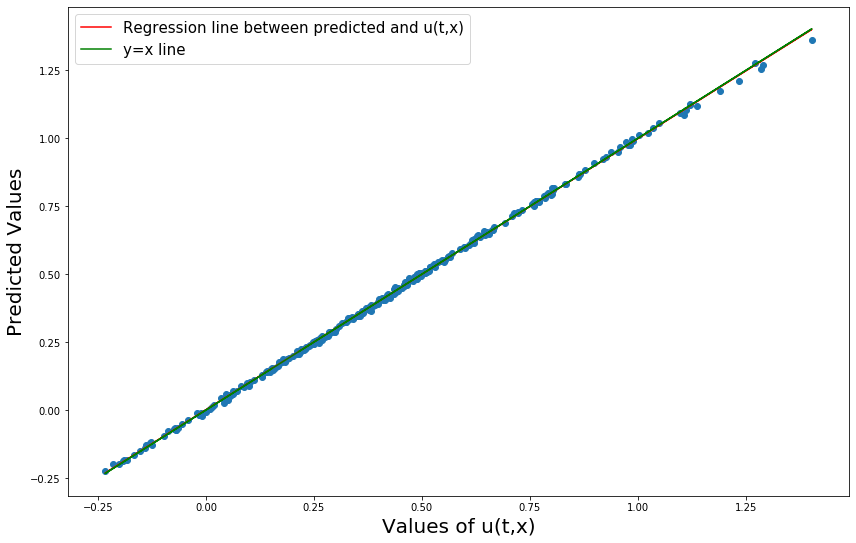

Error: 0.013486796683483604. Error std: 0.009420044182666879. Tangent: 0.9979481821819263. R^2: 0.9995101844833022.


In [29]:
# Prediction by algorithm 1 for the full model. 

t, x = -1, 50 # Point where prediction will be made
E = Experiment(t, x, t, x)
E.F = Features_for_points[(t,x)]
E.L = Wave_soln[:,t,x]
E.one_experiment(split = True)
E.show_regression_experiment(metric = err2)

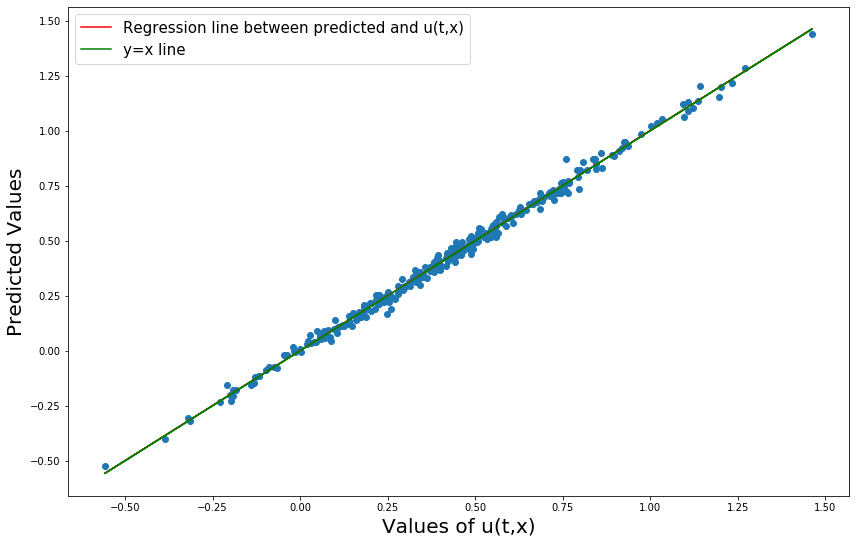

Error: 0.04300680028797421. Error std: 0.02961103395925947. Tangent: 1.000061161614708. R^2: 0.9950934011951137.


In [30]:
# Prediction by algorithm 1 for the model without initial speed. 

t, x = -1, 50 # Point where prediction will be made
E2 = Experiment(t, x, t, x)
E2.F = Features_for_points[(t,x)][trees_no_speed[4]]
E2.L = Wave_soln[:,t,x]
E2.one_experiment(split = True)
E2.show_regression_experiment(metric = err2)

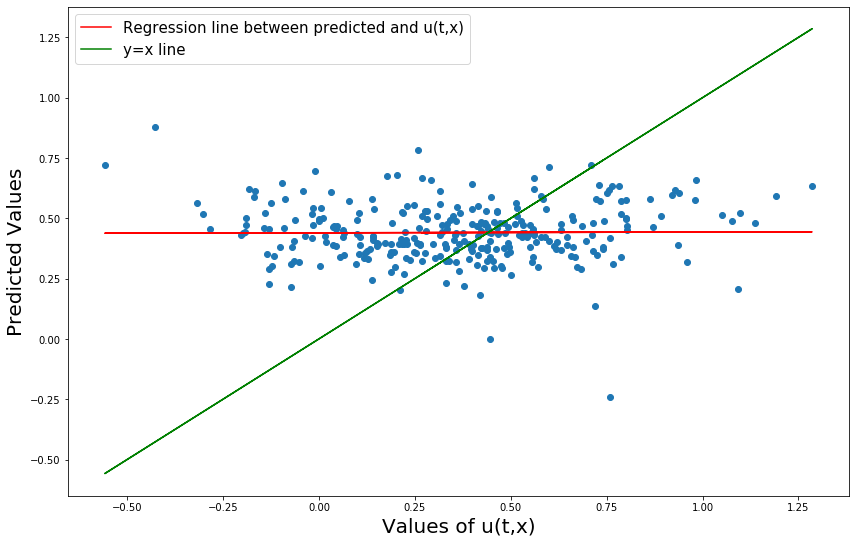

Error: 0.7213230088951149. Error std: 0.5073595944319775. Tangent: 0.002996006175148832. R^2: -0.20906473129828163.


In [31]:
# Prediction by algorithm 1 for the model without initial conditions. 

t, x = -1, 50 # Point where prediction will be made
E3 = Experiment(t, x, t, x)
E3.F = Features_for_points[(t,x)][no_initial]
E3.L = Wave_soln[:,t,x]
E3.one_experiment(split = True)
E3.show_regression_experiment(metric = err2)

In [32]:
#  Wave equation repeated experiments with full model

repeat_num = 1000
er1, std1, t1, r1 = E.many_regression_experiments(repeat_num, columns = trees[1])
er2, std2, t2, r2 = E.many_regression_experiments(repeat_num, columns = trees[2])
er3, std3, t3, r3 = E.many_regression_experiments(repeat_num, columns = trees[3])
er4, std4, t4, r4 = E.many_regression_experiments(repeat_num, columns = trees[4])
er1, std1, t1, r1 = round(100*er1, 2), round(100*std1, 2), round(t1, 3), round(r1, 3)
er2, std2, t2, r2 = round(100*er2, 2), round(100*std2, 2), round(t2, 3), round(r2, 3)
er3, std3, t3, r3 = round(100*er3, 2), round(100*std3, 2), round(t3, 3), round(r3, 3)
er4, std4, t4, r4 = round(100*er4, 2), round(100*std4, 2), round(t4, 3), round(r4, 3)

100%|██████████| 1000/1000 [00:14<00:00, 69.82it/s]


In [33]:
print('Repeating Experiment {} times.'.format(repeat_num))
print("Height = {}, Avg Error: {}%. Avg Error Std {}%. Avg Slope {}. Avg R^2 {}.".format(1, er1, std1, t1, r1))
print("Height = {}, Avg Error: {}%. Avg Error Std {}%. Avg Slope {}. Avg R^2 {}.".format(2, er2, std2, t2, r2))
print("Height = {}, Avg Error: {}%. Avg Error Std {}%. Avg Slope {}. Avg R^2 {}.".format(3, er3, std3, t3, r3))
print("Height = {}, Avg Error: {}%. Avg Error Std {}%. Avg Slope {}. Avg R^2 {}.".format(4, er4, std4, t4, r4))

Repeating Experiment 1000 times.
Height = 1, Avg Error: 59.83%. Avg Error Std 40.4%. Avg Slope 0.035. Avg R^2 0.029.
Height = 2, Avg Error: 12.78%. Avg Error Std 9.3%. Avg Slope 0.957. Avg R^2 0.956.
Height = 3, Avg Error: 2.14%. Avg Error Std 1.59%. Avg Slope 0.999. Avg R^2 0.999.
Height = 4, Avg Error: 1.39%. Avg Error Std 0.99%. Avg Slope 0.999. Avg R^2 0.999.


In [34]:
#  Wave equation repeated experiments with model without speed

repeat_num = 1000
er1, std1, t1, r1 = E2.many_regression_experiments(repeat_num, columns = trees_no_speed[1])
er2, std2, t2, r2 = E2.many_regression_experiments(repeat_num, columns = trees_no_speed[2])
er3, std3, t3, r3 = E2.many_regression_experiments(repeat_num, columns = trees_no_speed[3])
er4, std4, t4, r4 = E2.many_regression_experiments(repeat_num, columns = trees_no_speed[4])
er1, std1, t1, r1 = round(100*er1, 2), round(100*std1, 2), round(t1, 3), round(r1, 3)
er2, std2, t2, r2 = round(100*er2, 2), round(100*std2, 2), round(t2, 3), round(r2, 3)
er3, std3, t3, r3 = round(100*er3, 2), round(100*std3, 2), round(t3, 3), round(r3, 3)
er4, std4, t4, r4 = round(100*er4, 2), round(100*std4, 2), round(t4, 3), round(r4, 3)

100%|██████████| 1000/1000 [00:13<00:00, 71.83it/s]


In [35]:
print('Repeating Experiment without trees containing initial speed {} times.'.format(repeat_num))
print("Height = {}, Avg Error: {}%. Avg Error Std {}%. Avg Slope {}. Avg R^2 {}.".format(1, er1, std1, t1, r1))
print("Height = {}, Avg Error: {}%. Avg Error Std {}%. Avg Slope {}. Avg R^2 {}.".format(2, er2, std2, t2, r2))
print("Height = {}, Avg Error: {}%. Avg Error Std {}%. Avg Slope {}. Avg R^2 {}.".format(3, er3, std3, t3, r3))
print("Height = {}, Avg Error: {}%. Avg Error Std {}%. Avg Slope {}. Avg R^2 {}.".format(4, er4, std4, t4, r4))

Repeating Experiment without trees containing initial speed 1000 times.
Height = 1, Avg Error: 59.81%. Avg Error Std 40.4%. Avg Slope 0.034. Avg R^2 0.028.
Height = 2, Avg Error: 13.79%. Avg Error Std 9.86%. Avg Slope 0.95. Avg R^2 0.948.
Height = 3, Avg Error: 4.99%. Avg Error Std 3.47%. Avg Slope 0.994. Avg R^2 0.993.
Height = 4, Avg Error: 4.27%. Avg Error Std 2.95%. Avg Slope 0.995. Avg R^2 0.995.
